## Landscape Recognition: Image Classification

Dataset Source: https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images

#### Import Necessary Libraries

In [1]:
import os, sys, random
os.environ['TOKENIZERS_PARALLELISM']='false'

from PIL import ImageDraw, ImageFont, Image
import PIL.Image

from tqdm import tqdm

import numpy as np
import pandas as pd

import datasets
from datasets import load_dataset, Image, DatasetDict

import transformers
from transformers import Trainer, TrainingArguments
from transformers import ViTForImageClassification, ViTFeatureExtractor

import torch

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Libraries

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("NumPy:".rjust(15), np.__version__)
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Torch:".rjust(15), torch.__version__)

        Python: 3.9.12
         NumPy: 1.23.5
        Pandas: 2.0.0
      Datasets: 2.11.0
  Transformers: 4.27.4
         Torch: 2.0.0


#### Ingest Training Dataset

In [3]:
train_dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/current projects/Landscape Recognition/Landscape Classification/Training Data", 
                        drop_labels=False)

train_dataset

Resolving data files:   0%|          | 0/10000 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-2aaf91e69368d898/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

#### Ingest Evaluation Dataset

In [4]:
eval_dataset = load_dataset("imagefolder", 
                        data_dir="/Users/briandunn/Desktop/current projects/Landscape Recognition/Landscape Classification/Validation Data", 
                        drop_labels=False)

eval_dataset

Resolving data files:   0%|          | 0/1500 [00:00<?, ?it/s]

Found cached dataset imagefolder (/Users/briandunn/.cache/huggingface/datasets/imagefolder/default-ada820a6687d6713/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1500
    })
})

#### Combine Datasets into Dataset Dictationary

In [5]:
ds = DatasetDict({
    'train': train_dataset['train'],
    'eval': eval_dataset['train']
})

#### Display Grid of Examples From Each Class to Gain Better Picture of Data

In [6]:
def show_grid_of_examples(ds, 
                          seed: int = 42, 
                          examples_per_class: int = 3, 
                          size=(350, 350)):
    '''
    This function displays a few pictures
    from each class in the dataset.
    '''
    w, h = size
    labels = ds['train'].features['label'].names
    grid = PIL.Image.new(mode='RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("Chalkduster.ttf", 24)
    
    for label_id, label in enumerate(labels):
        # filter the dataset by a single label, shuffle it, then grab a few samples
        ds_slice = ds['train'] \
                    .filter(lambda ex: ex['label'] == label_id) \
                    .shuffle(seed) \
                    .select(range(examples_per_class))
        
        # plot this label's examples in a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font, dill=(0,0,255,1.0))
    
    return grid

#### Display Example Images From Each Class

Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-2aaf91e69368d898/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-958d8fdcfdc27b9a.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-2aaf91e69368d898/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-c3e0c76961cdadea.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-2aaf91e69368d898/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-cfb716d81ea2dfcd.arrow
Loading cached shuffled indices for dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-2aaf91e69368d898/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f/cache-8556bdcf120879c1.arrow
Loading cached processed dataset at /Users/briandunn/.cache/huggingface/datasets/imagefolder/default-2aaf9

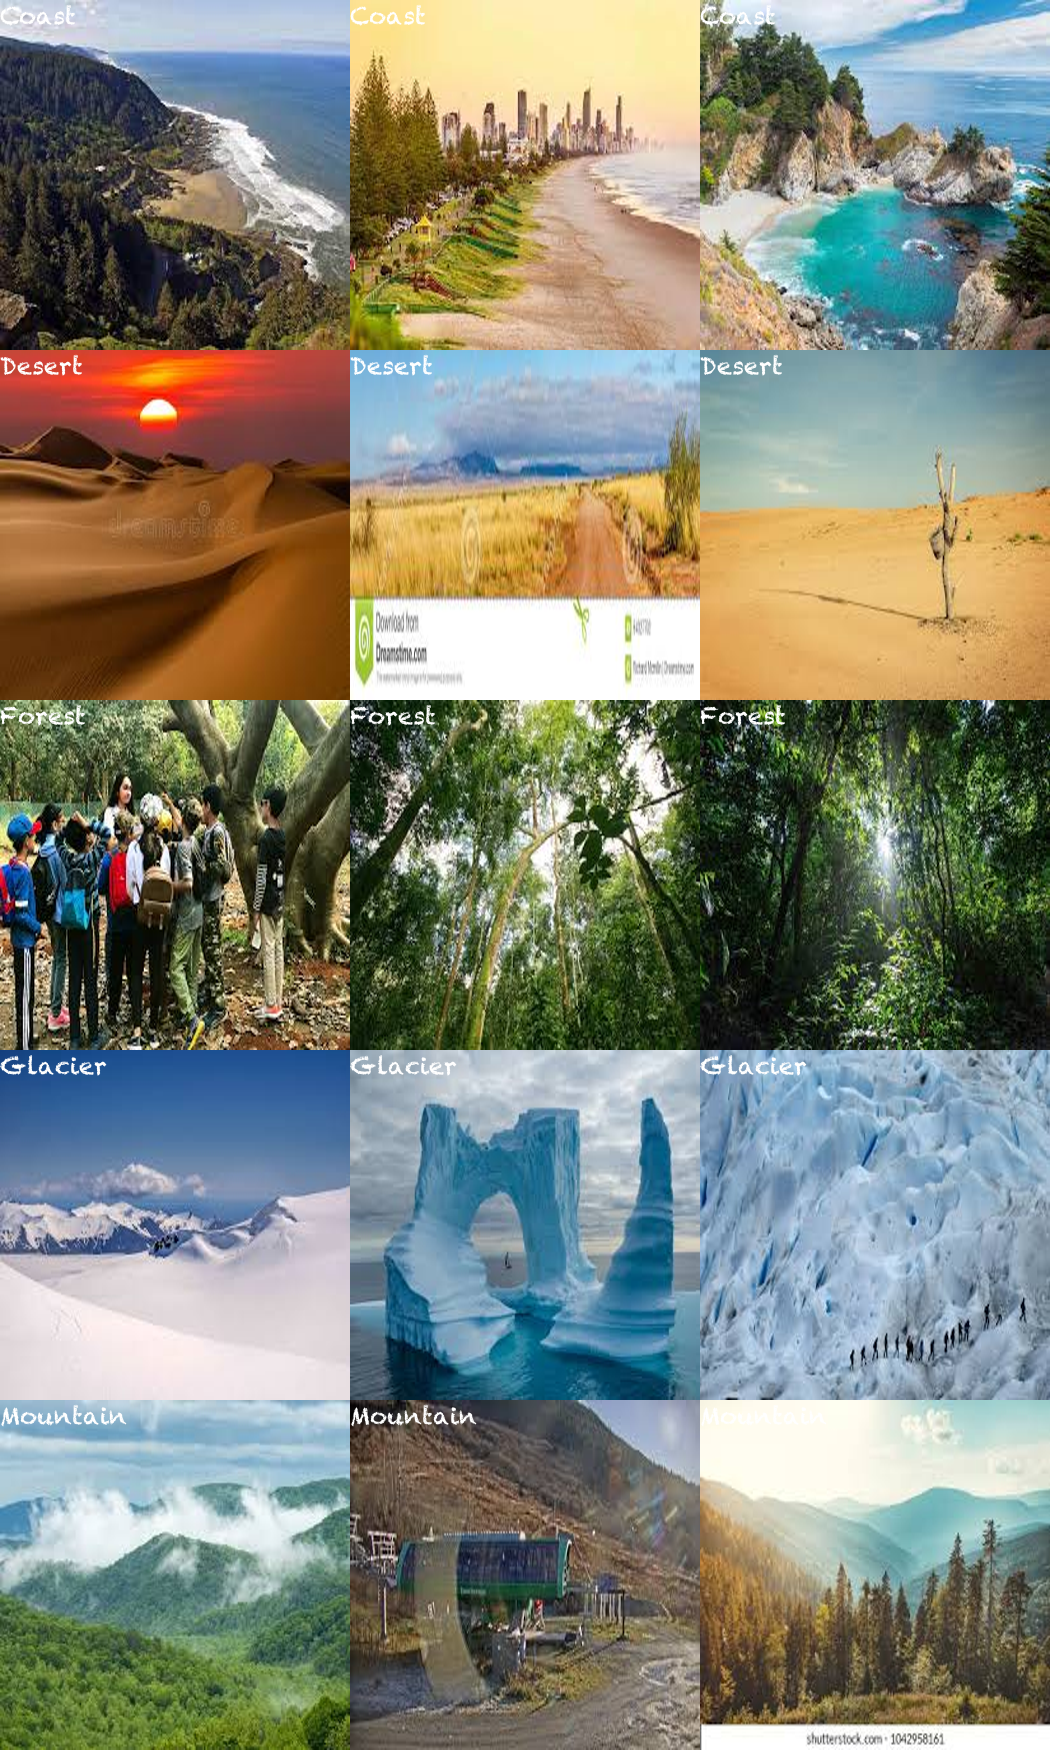

In [8]:
show_grid_of_examples(ds, seed=42, examples_per_class=3)

#### Basic Values/Constants

In [9]:
MODEL_CKPT='google/vit-base-patch16-224-in21k'
MODEL_NAME = MODEL_CKPT.split("/")[-1] + '-Landscape_Recognition'

NUM_OF_EPOCHS=3
LEARNING_RATE=2e-4

STEPS=100
BATCH_SIZE=16

DEVICE = torch.device("cpu")
REPORTS_TO='tensorboard'

#### Load ViT Feature Extractor

In [10]:
feature_extractor = ViTFeatureExtractor.from_pretrained(MODEL_CKPT)

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


#### Preprocessing Dataset

In [11]:
def transform(sample_batch):
    # take a list of PIL images and turn them into pixel values
    inputs = feature_extractor([x for x in sample_batch['image']], return_tensors="pt")
    
    # prepare labels
    inputs['labels'] = sample_batch['label']
    return inputs

#### Apply Transform Function to Dataset

In [12]:
prepped_ds = ds.with_transform(transform)

#### Define Data Collator

In [13]:
def data_collator(batch):
    return {
        'pixel_values' : torch.stack([x['pixel_values'] for x in batch]),
        'labels' : torch.tensor([x['labels'] for x in batch])
    }

#### Define Evaluation Metric

In [14]:
def compute_metrics(p):
    accuracy_metric = evaluate.load("accuracy")
    accuracy = accuracy_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)['accuracy']
    
    ### ------------------- F1 scores -------------------
    
    f1_score_metric = evaluate.load("f1")
    weighted_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["f1"]
    micro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')['f1']
    macro_f1_score = f1_score_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["f1"]
    
    ### ------------------- recall -------------------
    
    recall_metric = evaluate.load("recall")
    weighted_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["recall"]
    micro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["recall"]
    macro_recall = recall_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["recall"]
    
    ### ------------------- precision -------------------
    
    precision_metric = evaluate.load("precision")
    weighted_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='weighted')["precision"]
    micro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='micro')["precision"]
    macro_precision = precision_metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids, average='macro')["precision"]
    
    return {"accuracy" : accuracy, 
            "Weighted F1" : weighted_f1_score,
            "Micro F1" : micro_f1_score,
            "Macro F1" : macro_f1_score,
            "Weighted Recall" : weighted_recall,
            "Micro Recall" : micro_recall,
            "Macro Recall" : macro_recall,
            "Weighted Precision" : weighted_precision,
            "Micro Precision" : micro_precision,
            "Macro Precision" : macro_precision
            }

#### Load Pretrained Model

In [15]:
labels = ds['train'].features['label'].names

model = ViTForImageClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
).to(DEVICE)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Define Training Arguments

In [16]:
args = TrainingArguments(
    output_dir=MODEL_NAME,
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    report_to=REPORTS_TO,
    disable_tqdm=False,
    load_best_model_at_end=True,
    metric_for_best_model="Weighted F1",
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=100,
    hub_private_repo=True,
    push_to_hub=True
)

#### Instantiate Trainer

In [17]:
trainer = Trainer(
    model = model,
    args= args,
    data_collator = data_collator,
    compute_metrics = compute_metrics,
    train_dataset=prepped_ds['train'],
    eval_dataset=prepped_ds['eval'],
    tokenizer=feature_extractor,
)

Cloning https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Landscape_Recognition into local empty directory.


#### Train Model

In [18]:
train_results = trainer.train()

/Users/briandunn/Documents/deep_learning/dl/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1875 [00:00<?, ?it/s]

{'loss': 1.5881, 'learning_rate': 0.00019989333333333333, 'epoch': 0.0}
{'loss': 0.6192, 'learning_rate': 0.00018933333333333335, 'epoch': 0.16}
{'loss': 0.4104, 'learning_rate': 0.00017866666666666668, 'epoch': 0.32}
{'loss': 0.4125, 'learning_rate': 0.000168, 'epoch': 0.48}
{'loss': 0.3686, 'learning_rate': 0.00015733333333333333, 'epoch': 0.64}
{'loss': 0.3467, 'learning_rate': 0.00014666666666666666, 'epoch': 0.8}
{'loss': 0.2866, 'learning_rate': 0.00013600000000000003, 'epoch': 0.96}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.43082812428474426, 'eval_accuracy': 0.8486666666666667, 'eval_Weighted F1': 0.8538115673895048, 'eval_Micro F1': 0.8486666666666667, 'eval_Macro F1': 0.8538115673895048, 'eval_Weighted Recall': 0.8486666666666667, 'eval_Micro Recall': 0.8486666666666667, 'eval_Macro Recall': 0.8486666666666667, 'eval_Weighted Precision': 0.8699612982869261, 'eval_Micro Precision': 0.8486666666666667, 'eval_Macro Precision': 0.8699612982869261, 'eval_runtime': 662.8116, 'eval_samples_per_second': 2.263, 'eval_steps_per_second': 0.284, 'epoch': 1.0}
{'loss': 0.2163, 'learning_rate': 0.00012533333333333334, 'epoch': 1.12}
{'loss': 0.2037, 'learning_rate': 0.00011466666666666667, 'epoch': 1.28}
{'loss': 0.1725, 'learning_rate': 0.00010400000000000001, 'epoch': 1.44}
{'loss': 0.1775, 'learning_rate': 9.333333333333334e-05, 'epoch': 1.6}
{'loss': 0.185, 'learning_rate': 8.266666666666667e-05, 'epoch': 1.76}
{'loss': 0.1522, 'learning_rate': 7.2e-05, 'epoch': 1.92}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.4647742211818695, 'eval_accuracy': 0.8686666666666667, 'eval_Weighted F1': 0.8694262568981097, 'eval_Micro F1': 0.8686666666666667, 'eval_Macro F1': 0.8694262568981099, 'eval_Weighted Recall': 0.8686666666666667, 'eval_Micro Recall': 0.8686666666666667, 'eval_Macro Recall': 0.8686666666666667, 'eval_Weighted Precision': 0.8714057110442778, 'eval_Micro Precision': 0.8686666666666667, 'eval_Macro Precision': 0.8714057110442777, 'eval_runtime': 658.689, 'eval_samples_per_second': 2.277, 'eval_steps_per_second': 0.285, 'epoch': 2.0}
{'loss': 0.1266, 'learning_rate': 6.133333333333334e-05, 'epoch': 2.08}
{'loss': 0.0675, 'learning_rate': 5.0666666666666674e-05, 'epoch': 2.24}
{'loss': 0.0642, 'learning_rate': 4e-05, 'epoch': 2.4}
{'loss': 0.0505, 'learning_rate': 2.9333333333333336e-05, 'epoch': 2.56}
{'loss': 0.0553, 'learning_rate': 1.866666666666667e-05, 'epoch': 2.72}
{'loss': 0.0609, 'learning_rate': 8.000000000000001e-06, 'epoch': 2.88}


  0%|          | 0/188 [00:00<?, ?it/s]

{'eval_loss': 0.5121961236000061, 'eval_accuracy': 0.866, 'eval_Weighted F1': 0.8678320528187684, 'eval_Micro F1': 0.866, 'eval_Macro F1': 0.8678320528187685, 'eval_Weighted Recall': 0.866, 'eval_Micro Recall': 0.866, 'eval_Macro Recall': 0.866, 'eval_Weighted Precision': 0.871010836982482, 'eval_Micro Precision': 0.866, 'eval_Macro Precision': 0.8710108369824822, 'eval_runtime': 660.7562, 'eval_samples_per_second': 2.27, 'eval_steps_per_second': 0.285, 'epoch': 3.0}
{'train_runtime': 37947.6864, 'train_samples_per_second': 0.791, 'train_steps_per_second': 0.049, 'train_loss': 0.21468871523539226, 'epoch': 3.0}


#### Save Model as Well as Log & Save Metrics of Training Dataset

In [19]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Apr29_22-16-20_Brians-Mac-mini.local/events.out.tfevents.1682824586.Brians-Mac-mini.local.602…

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Landscape_Recognition
   1bd9892..2631e66  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Landscape_Recognition
   2631e66..8a04648  main -> main



***** train metrics *****
  epoch                    =         3.0
  train_loss               =      0.2147
  train_runtime            = 10:32:27.68
  train_samples_per_second =       0.791
  train_steps_per_second   =       0.049


#### Evaluate Model & Save Metrics

In [20]:
metrics = trainer.evaluate(prepped_ds['eval'])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

  0%|          | 0/188 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_Macro F1           =     0.8694
  eval_Macro Precision    =     0.8714
  eval_Macro Recall       =     0.8687
  eval_Micro F1           =     0.8687
  eval_Micro Precision    =     0.8687
  eval_Micro Recall       =     0.8687
  eval_Weighted F1        =     0.8694
  eval_Weighted Precision =     0.8714
  eval_Weighted Recall    =     0.8687
  eval_accuracy           =     0.8687
  eval_loss               =     0.4648
  eval_runtime            = 0:11:02.58
  eval_samples_per_second =      2.264
  eval_steps_per_second   =      0.284


#### Push Model to Hub (My Profile!)

In [21]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-classification",
    "tags" : ["image-classification"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

Upload file runs/Apr29_22-16-20_Brians-Mac-mini.local/events.out.tfevents.1682863698.Brians-Mac-mini.local.602…

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Landscape_Recognition
   8a04648..763032a  main -> main

To https://huggingface.co/DunnBC22/vit-base-patch16-224-in21k-Landscape_Recognition
   763032a..3630875  main -> main



### Notes & Other Takeaways
****
- I was expecting better results.
****

### Citation

- Model Checkpoint
    > @misc{wu2020visual, title={Visual Transformers: Token-based Image Representation and Processing for Computer Vision}, author={Bichen Wu and Chenfeng Xu and Xiaoliang Dai and Alvin Wan and Peizhao Zhang and Zhicheng Yan and Masayoshi Tomizuka and Joseph Gonzalez and Kurt Keutzer and Peter Vajda}, year={2020}, eprint={2006.03677}, archivePrefix={arXiv}, primaryClass={cs.CV}}
    
    > @inproceedings{deng2009imagenet, title={Imagenet: A large-scale hierarchical image database}, author={Deng, Jia and Dong, Wei and Socher, Richard and Li, Li-Jia and Li, Kai and Fei-Fei, Li}, booktitle={2009 IEEE conference on computer vision and pattern recognition}, pages={248--255}, year={2009}, organization={Ieee}}

